New York City's geographic coordinates roughly span from 40.49°N to 40.92°N latitude and -74.26°W to -73.70°W longitude. 
Geojson data is available here: https://www.nyc.gov/content/planning/pages/resources/datasets/neighborhood-tabulation
The nyc_taxi dataset contains entries since 2009, and the neighbourhood tabulation area (NTA) names suggest the 2010 neighbourhood tabulation is more accurate for the dataset visualization. (2020 geojson contains ~250 NTAs, there are ~190 in nyc_taxi and the 2010 geojson)



In [1]:
from clickhouse_connect import get_client
import pandas as pd
import geopandas as gpd

client = get_client(database="nyc_taxi")

geos = client.query(f"""select 
                        pickup_latitude, 
                        pickup_longitude, 
                        dropoff_latitude, 
                        dropoff_longitude,
                        pickup_ntaname,
                        dropoff_ntaname
                        from trips_small"""
                         )

geo_coords = pd.DataFrame(geos.result_rows, columns=geos.column_names)

In [2]:
nta_counts = geo_coords.groupby("pickup_ntaname").size().sort_values(ascending=False).copy()
nyc_nta = gpd.read_file("../data/nynta2010_25d/nynta2010.shp")
nyc_nta_wm = nyc_nta.to_crs(epsg=3857)
print(nyc_nta_wm.NTAName)

0                       St. Albans
1                    East Flushing
2                          Madison
3         Kensington-Ocean Parkway
4                  Cambria Heights
                  ...             
190    park-cemetery-etc-Manhattan
191                  College Point
192                     Whitestone
193                      Rego Park
194                 Middle Village
Name: NTAName, Length: 195, dtype: object


TODO: use the same color scale for pickups and dropoffs

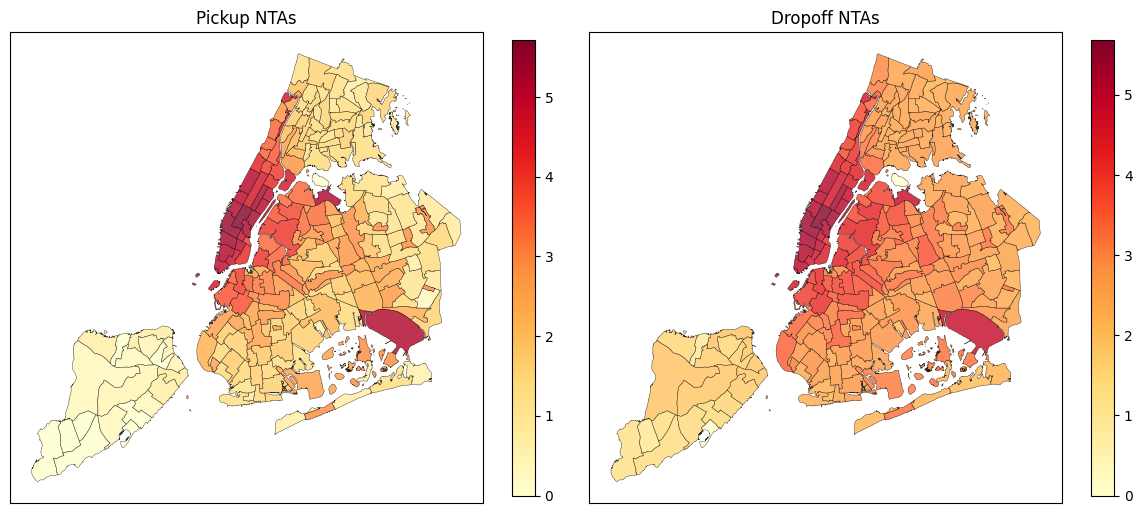

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np


def plot_nta_counts(nta_counts, nyc_nta_wm, ax):    
    # Prepare NTA counts for joining
    nta_counts_df = nta_counts.reset_index()
    nta_counts_df.columns = ['NTAName', 'count']

    # Join NTA boundaries with pickup counts
    nyc_nta_wm_with_counts = nyc_nta_wm.merge(nta_counts_df,on='NTAName',how='left')
    nyc_nta_wm_with_counts['count'] = np.log10(nyc_nta_wm_with_counts['count'].fillna(1))

    # Plot NTA boundaries colored by pickup count
    nyc_nta_wm_with_counts.plot(ax=ax,column='count',cmap='YlOrRd',edgecolor='black',linewidth=0.3,alpha=0.8,legend=True,legend_kwds={'shrink': 0.8,'orientation': 'vertical'}
    )
    # cx.add_basemap(ax, crs=nyc_nta_wm.crs, source=cx.providers.CartoDB.Positron)
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

nta_pickups = geo_coords.groupby("pickup_ntaname").size().sort_values(ascending=False).copy()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_nta_counts(nta_pickups, nyc_nta_wm, ax[0])
ax[0].set_title("Pickup NTAs")
nta_dropoffs = geo_coords.groupby("dropoff_ntaname").size().sort_values(ascending=False).copy()
ax2 = plot_nta_counts(nta_dropoffs, nyc_nta_wm, ax[1])
ax2.set_title("Dropoff NTAs")
plt.tight_layout()
plt.show()


(2954097, 6) with 98.46% of all trips


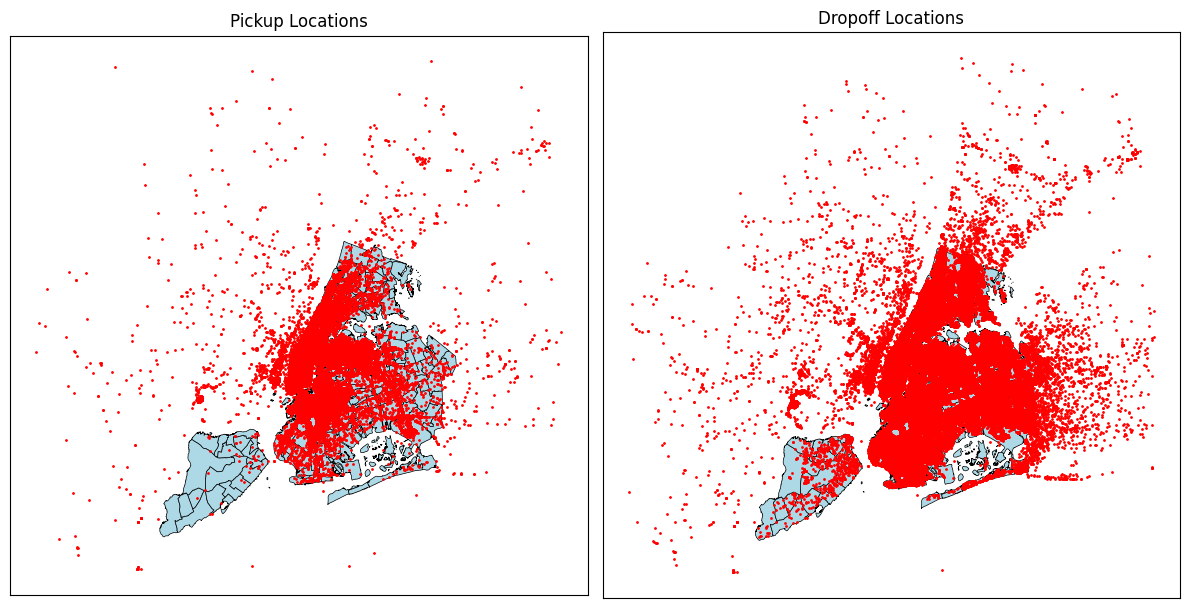

In [4]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx

geo_coords_ny = geo_coords.copy()
geo_coords_ny = geo_coords_ny[geo_coords_ny.pickup_latitude > 40.45]
geo_coords_ny = geo_coords_ny[geo_coords_ny.pickup_latitude < 41.2]
geo_coords_ny = geo_coords_ny[geo_coords_ny.pickup_longitude > -74.5]
geo_coords_ny = geo_coords_ny[geo_coords_ny.pickup_longitude < -73.5]
geo_coords_ny = geo_coords_ny[geo_coords_ny.dropoff_latitude > 40.45]
geo_coords_ny = geo_coords_ny[geo_coords_ny.dropoff_latitude < 41.2]
geo_coords_ny = geo_coords_ny[geo_coords_ny.dropoff_longitude > -74.5]
geo_coords_ny = geo_coords_ny[geo_coords_ny.dropoff_longitude < -73.5]

def plot_geo_counts(geo_coords, nyc_nta_wm):
    nyc_nta_geo = nyc_nta_wm.to_crs(epsg=4326)
    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    for i in range(2):
        x = geo_coords.pickup_longitude if i == 0 else geo_coords.dropoff_longitude
        y = geo_coords.pickup_latitude if i == 0 else geo_coords.dropoff_latitude
        nyc_nta_geo.plot(ax=ax[i],alpha=1,edgecolor='black',facecolor='lightblue',linewidth=0.5,zorder=1)
        ax[i].scatter(x, y,alpha=1,s=1,c='red',zorder=2)
        # ax[i].set_xlim(-74.5, -73.5)  # NYC longitude bounds
        # ax[i].set_ylim(40.45, 41.2)    # NYC latitude bounds
        ax[i].set_title(f"{'Pickup' if i == 0 else 'Dropoff'} Locations")
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.tight_layout()
    plt.show()

print(geo_coords_ny.shape, f"with {geo_coords_ny.shape[0] / geo_coords.shape[0] * 100:.02f}% of all trips")
plot_geo_counts(geo_coords_ny, nyc_nta_wm)

Rounding the geo coords down to 2 (3) decimal places results in localization cell dimensions of approximately 1100 m x 840 m (111 m x 84 m) 

(2945412, 6) with 98.17% non-empty NTAs


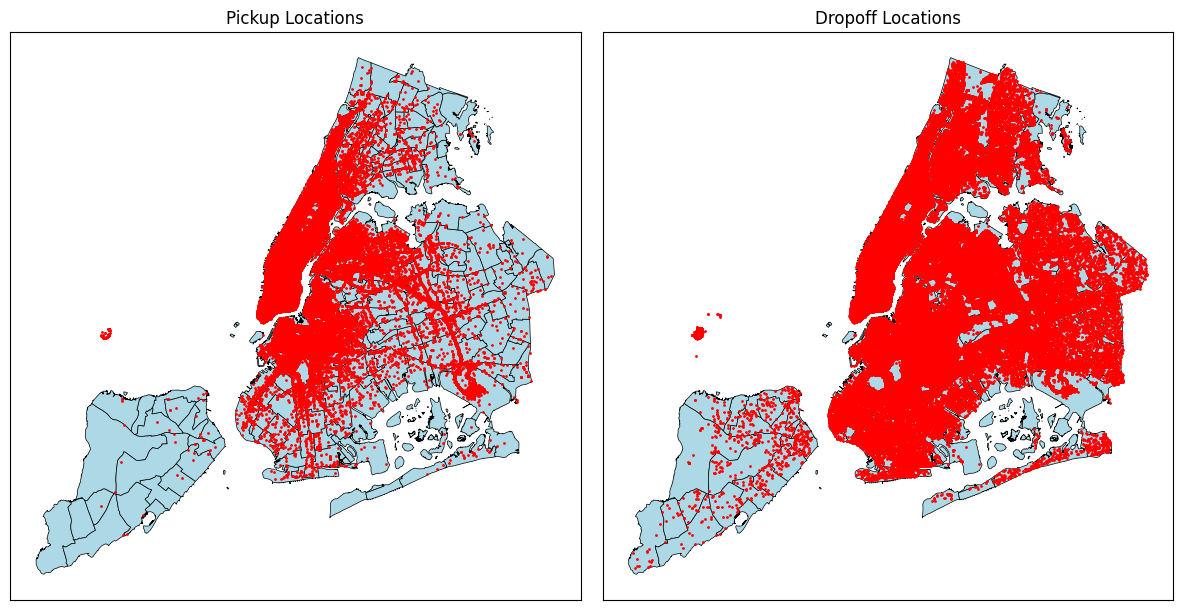

In [5]:
geo_nta_nonempty = geo_coords.copy()
geo_nta_nonempty = geo_nta_nonempty[(geo_nta_nonempty.pickup_ntaname != '') & (geo_nta_nonempty.dropoff_ntaname != '')]

print(geo_nta_nonempty.shape, f"with {geo_nta_nonempty.shape[0] / geo_coords.shape[0] * 100:.02f}% non-empty NTAs")
plot_geo_counts(geo_nta_nonempty, nyc_nta_wm)

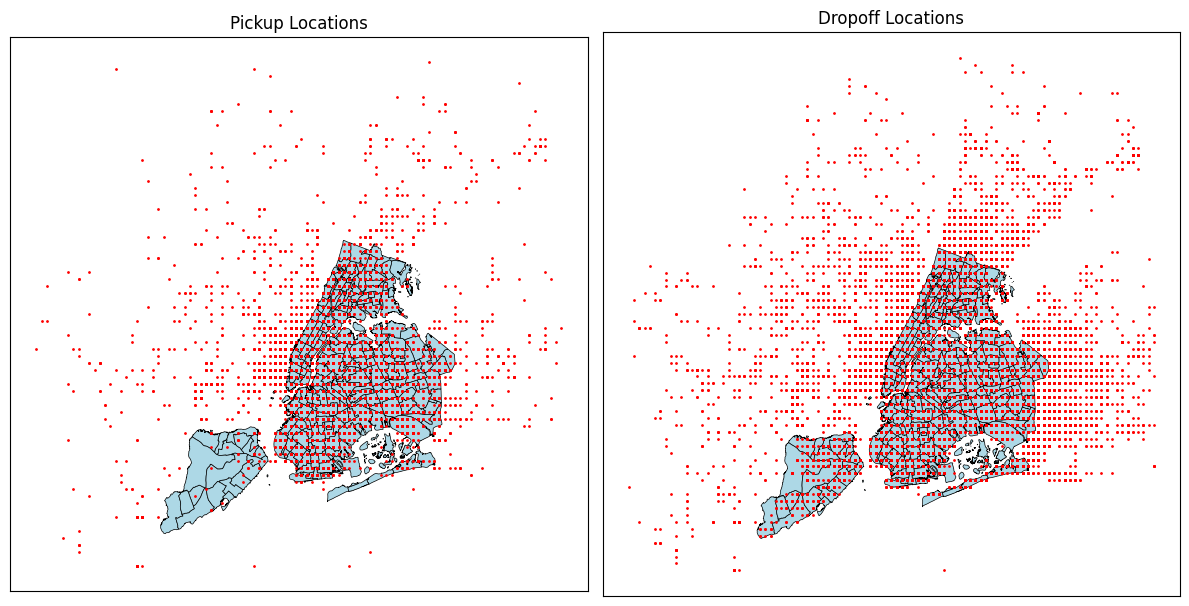

In [6]:
geo_nta_rounded = geo_coords_ny.copy()
geo_nta_rounded = geo_nta_rounded.round(2)

plot_geo_counts(geo_nta_rounded, nyc_nta_wm)


In [45]:
uid_geo = "cityHash64(array(round(pickup_latitude, 2), round(pickup_longitude, 2))) as uid"
uid_geo_fine = "cityHash64(array(round(pickup_latitude, 3), round(pickup_longitude, 3))) as uid"
uid_nta = "cityHash64(pickup_ntaname) as uid"

where_geo = "where pickup_latitude between 40.45 and 41.2 and pickup_longitude between -74.5 and -73.5"
where_nta = "where pickup_ntaname != ''"

query = """with data as (select {uid}, 
                count(trip_id) as trips,
                toDate(pickup_datetime) as date, 
                sum(total_amount) as amount
            from trips_small
            {where}
            group by uid, date
            order by date),
            labels as (
            select d1.uid, d1.date as prediction_date, d1.trips,
                if(d2.date is not null and d2.date <= d1.date + interval 7 day, 0, 1) as churn
                from data d1 asof join data d2
                on d1.uid=d2.uid
                and d1.date < d2.date
                order by date)"""


data_geo = client.query(query.format(uid=uid_geo, where=where_geo) + "select * from labels")
data_nta = client.query(query.format(uid=uid_nta, where=where_nta) + "select * from labels")
data_geo_fine = client.query(query.format(uid=uid_geo_fine, where=where_geo) + "select * from labels")

labels_geo = pd.DataFrame(data_geo.result_rows, columns=data_geo.column_names)
labels_nta = pd.DataFrame(data_nta.result_rows, columns=data_nta.column_names)
labels_geo_fine = pd.DataFrame(data_geo_fine.result_rows, columns=data_geo_fine.column_names)
print(labels_geo[labels_geo.churn == 1].shape[0],labels_geo[labels_geo.churn == 0].shape[0], np.round(labels_geo[labels_geo.churn == 1].shape[0] / labels_geo.shape[0], 4))
print(labels_nta[labels_nta.churn == 1].shape[0],labels_nta[labels_nta.churn == 0].shape[0], np.round(labels_nta[labels_nta.churn == 1].shape[0] / labels_nta.shape[0], 4))
print(labels_geo_fine[labels_geo_fine.churn == 1].shape[0],labels_geo_fine[labels_geo_fine.churn == 0].shape[0], np.round(labels_geo_fine[labels_geo_fine.churn == 1].shape[0] / labels_geo_fine.shape[0], 4))

1211 20435 0.0559
214 9100 0.023
14714 310158 0.0453


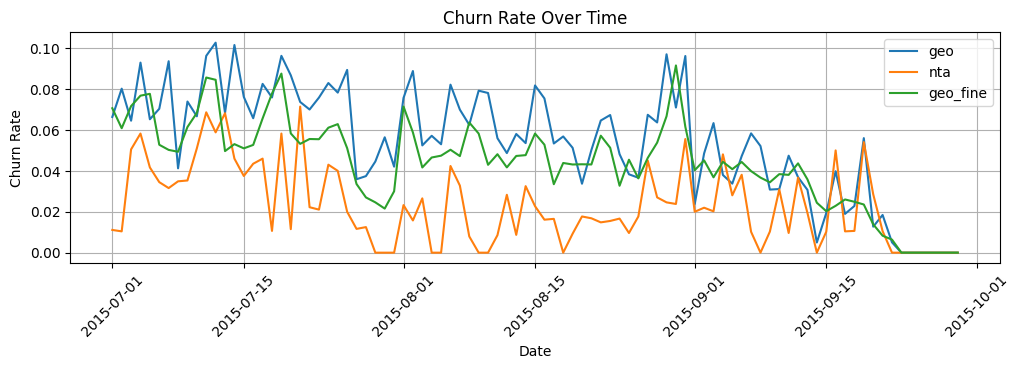

In [53]:
def churn_over_time(data):
    freq = data[['churn', 'prediction_date']].groupby("prediction_date", as_index=False).mean()
    return freq


fig = plt.figure(figsize=(12, 3))
freq = churn_over_time(labels_geo)
plt.plot(freq.prediction_date, freq.churn, label="geo")
freq = churn_over_time(labels_nta)
plt.plot(freq.prediction_date, freq.churn, label="nta")
freq = churn_over_time(labels_geo_fine)
plt.plot(freq.prediction_date, freq.churn, label="geo_fine")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Churn Rate")
plt.title("Churn Rate Over Time")
plt.xticks(rotation=45)
plt.grid()
plt.show()



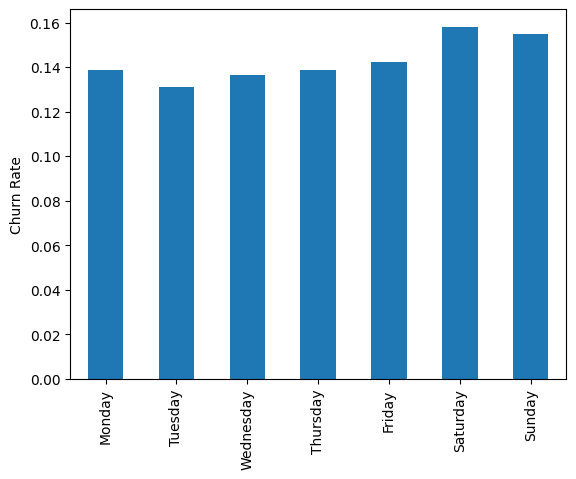

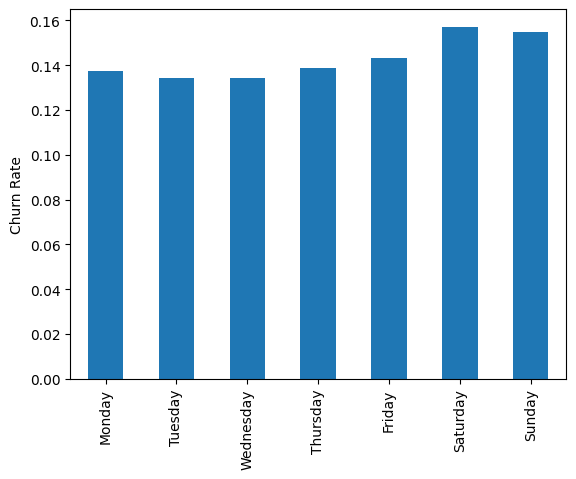

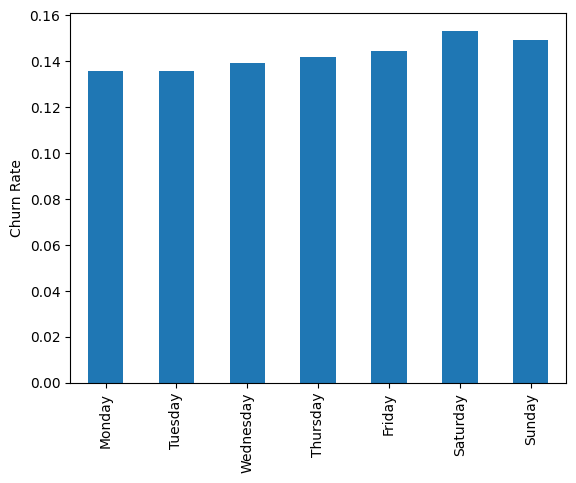

In [67]:
def churn_by_weekday(data):
    data["day_of_week"] = pd.to_datetime(data["prediction_date"]).dt.day_name()
    hist = data["day_of_week"].value_counts().reindex(
        ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    ) / data.shape[0]

    hist.plot(kind="bar")
    plt.ylabel("Churn Rate")
    plt.xlabel('')
    plt.show()

churn_by_weekday(labels_geo)
churn_by_weekday(labels_nta)
churn_by_weekday(labels_geo_fine)

/tmp/ipykernel_20566/1420607266.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "week_idx"] = ((pd.to_datetime(data["prediction_date"]) - start).dt.days // 7)
/tmp/ipykernel_20566/1420607266.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "week_idx"] = ((pd.to_datetime(data["prediction_date"]) - start).dt.days // 7)


   week_idx  trips  n_users
0         0      1      109
1         0      2        5
2         1      1      111
3         1      2        7
4         2      1      107
   week_idx  trips  n_users
0         0      1      357
1         0      2      159
2         0      3       67
3         0      4       73
4         0      5       38


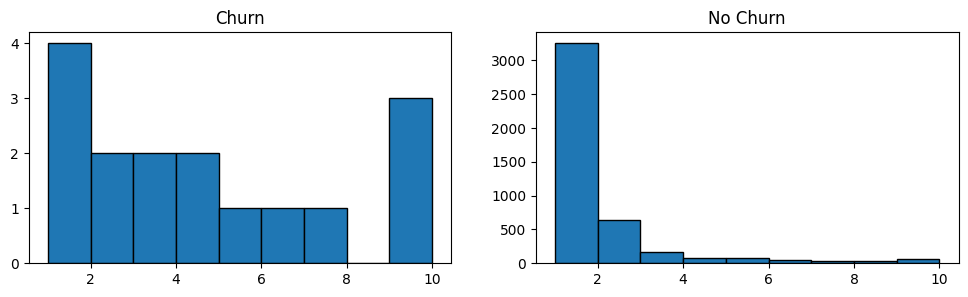

/tmp/ipykernel_20566/1420607266.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "week_idx"] = ((pd.to_datetime(data["prediction_date"]) - start).dt.days // 7)
/tmp/ipykernel_20566/1420607266.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "week_idx"] = ((pd.to_datetime(data["prediction_date"]) - start).dt.days // 7)


   week_idx  trips  n_users
0         0      1       19
1         0      2        4
2         1      1       28
3         1      2        5
4         1      3        1
   week_idx  trips  n_users
0         0      1      154
1         0      2       65
2         0      3       39
3         0      4       26
4         0      5       11


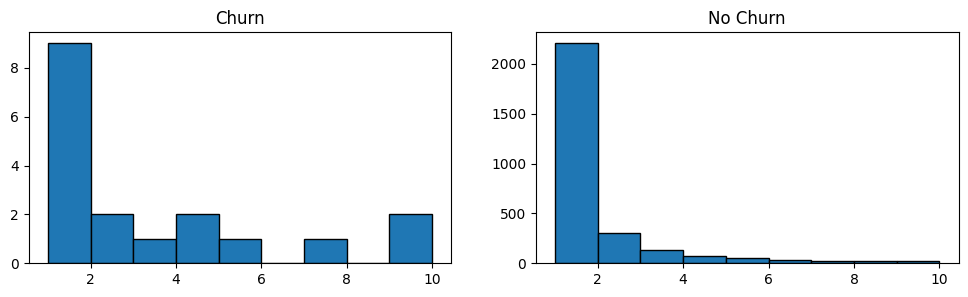

In [ ]:
def weekly(data):
    start = pd.to_datetime(data["prediction_date"].min())
    data.loc[:, "week_idx"] = ((pd.to_datetime(data["prediction_date"]) - start).dt.days // 7)
    data_weekly = data.groupby(["week_idx", "trips"]).size().reset_index(name="n_users")
    return data_weekly

def plot_weekly(data):
    data_churn = data[data["churn"] == 1]
    data_nochurn = data[data["churn"] == 0]
    churn_weekly = weekly(data_churn)
    nochurn_weekly = weekly(data_nochurn)
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))   
    ax[0].hist(churn_weekly["n_users"], bins=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], edgecolor='black')
    ax[0].set_title("Churn")
    ax[1].hist(nochurn_weekly["n_users"], bins=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], edgecolor='black')
    ax[1].set_title("No Churn")
    plt.show()


plot_weekly(labels_geo)
plot_weekly(labels_nta)

1211 20435 0.0559
214 9100 0.023
